This is a problem of building five houses in different locations; the masonry, roofing, painting, etc. must be scheduled. Some tasks must necessarily take place before others and these requirements are expressed through precedence constraints.

There are three workers, and each worker has a given skill level for each task. Each task requires one worker; the worker assigned must have a non-null skill level for the task. A worker can be assigned to only one task at a time.

The objective of this problem is to maximize the skill level used for all the tasks.

https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/jupyter/house_building.ipynb

https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/basic/house_building.py


In [20]:
from docplex.cp.model import CpoModel
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 35, 10
import docplex.cp.utils_visu as visu

# Data Creation

In [21]:
inputs = {}

Houses = pd.DataFrame([])
Houses['house']=[str(i) for i in range(1,6)]


Tasks = pd.DataFrame(\
    [   ["masonry",   35],
         ["carpentry", 15],
         ["plumbing",  40],
         ["ceiling",   15],
         ["roofing",    5],
         ["painting",  10],
         ["windows",    5],
         ["facade",    10],
         ["garden",     5],
         ["moving",     5]], columns = ["task", "duration"])



TaskPrecedence = pd.DataFrame\
                  ([["masonry",   "carpentry"],
                    ["masonry",   "plumbing"],
                    ["masonry",   "ceiling"],
                    ["carpentry", "roofing"],
                    ["ceiling",   "painting"],
                    ["roofing",   "windows"],
                    ["roofing",   "facade"],
                    ["plumbing",  "facade"],
                    ["roofing",   "garden"],
                    ["plumbing",  "garden"],
                    ["windows",   "moving"],
                    ["facade",    "moving"],
                    ["garden",    "moving"],
                    ["painting",  "moving"]], columns = ["beforeTask", "afterTask"])


Skills  =  pd.DataFrame\
        ([["Joe",  "masonry",   9],
          ["Joe",  "carpentry", 7],
          ["Joe",  "ceiling",   5],
          ["Joe",  "roofing",   6],
          ["Joe",  "windows",   8],
          ["Joe",  "facade",    5],
          ["Joe",  "garden",    5],
          ["Joe",  "moving",    6],
          ["Jack", "masonry",   5],
          ["Jack", "plumbing",  7],
          ["Jack", "ceiling",   8],
          ["Jack", "roofing",   7],
          ["Jack", "painting",  9],
          ["Jack", "facade",    5],
          ["Jack", "garden",    5],
          ["Jim",  "carpentry", 5],
          ["Jim",  "painting",  6],
          ["Jim",  "windows",   5],
          ["Jim",  "garden",    9],
          ["Jim",  "moving",    8]], columns = ["worker", "task", "level"] )
          

# Worker and continuity requirements: if the Task 1 is done on the house, he must do the task 2 in this house
Continuities = pd.DataFrame([
                ["Joe",  "masonry",   "carpentry"],
                ["Jack", "roofing",   "facade"],
                ["Joe",  "carpentry", "roofing"],
                ["Jim",  "garden",    "moving"]], columns = ["worker", "task1", "task2"])


inputs['Houses']= Houses
inputs['Tasks']= Tasks
inputs['TaskPrecedence']= TaskPrecedence
inputs['Skills']= Skills
inputs['Continuities']= Continuities

inputs.keys()

dict_keys(['Houses', 'Tasks', 'TaskPrecedence', 'Skills', 'Continuities'])

# Model Building

create model

In [22]:
mdl = CpoModel(name="HouseBuilding")

MAX_SCHEDULE = Tasks['duration'].sum()*5

Define Decision variables

In [23]:
# table of interval variable for each house and task
tasks = pd.merge(Houses, Tasks, how = 'cross')
tasks['TaskDV']=0
for index, row in tasks.iterrows():
    dv =  mdl.interval_var((0, MAX_SCHEDULE) , (0, MAX_SCHEDULE) , size=row.duration, name="house:{} task:{}".format(row.house, row.task))
    tasks.at[index, 'TaskDV']=dv

display(tasks.head())



#table of interval variable for each house and skill
wtasks = pd.merge(Houses, Skills, how = 'cross')
wtasks['SkillDV']=0
for index, row in wtasks.iterrows():
    dv =  mdl.interval_var(optional = True , name="house:{} worker:{} skill:{}".format(row.house, row.worker, row.task))
    wtasks.at[index, 'SkillDV']=dv


display(wtasks.head())

,house,task,duration,TaskDV
0,1,masonry,35,"""house:1 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)"
1,1,carpentry,15,"""house:1 task:carpentry"" = intervalVar(start=0..725, end=0..725, size=15)"
2,1,plumbing,40,"""house:1 task:plumbing"" = intervalVar(start=0..725, end=0..725, size=40)"
3,1,ceiling,15,"""house:1 task:ceiling"" = intervalVar(start=0..725, end=0..725, size=15)"
4,1,roofing,5,"""house:1 task:roofing"" = intervalVar(start=0..725, end=0..725, size=5)"


,house,worker,task,level,SkillDV
0,1,Joe,masonry,9,"""house:1 worker:Joe skill:masonry"" = intervalVar(optional)"
1,1,Joe,carpentry,7,"""house:1 worker:Joe skill:carpentry"" = intervalVar(optional)"
2,1,Joe,ceiling,5,"""house:1 worker:Joe skill:ceiling"" = intervalVar(optional)"
3,1,Joe,roofing,6,"""house:1 worker:Joe skill:roofing"" = intervalVar(optional)"
4,1,Joe,windows,8,"""house:1 worker:Joe skill:windows"" = intervalVar(optional)"


Define Constraints

In [24]:
# Temporal constraints.TASK_PRECEDENCES  

u = pd.merge(tasks,TaskPrecedence, left_on = 'task', right_on = 'beforeTask' )[['house', 'TaskDV', 'beforeTask','afterTask']].rename(columns = {'TaskDV':"TaskDV_before"})
v= pd.merge(u, tasks, left_on = ['afterTask','house'] , right_on = ['task','house']).rename(columns = {'TaskDV':"TaskDV_after"})[['house', 'TaskDV_before', 'beforeTask','afterTask','TaskDV_after']]
display(v.head())


for index, row in v.iterrows():
    mdl.add( mdl.end_before_start(row.TaskDV_before, row.TaskDV_after))


,house,TaskDV_before,beforeTask,afterTask,TaskDV_after
0,1,"""house:1 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)",masonry,carpentry,"""house:1 task:carpentry"" = intervalVar(start=0..725, end=0..725, size=15)"
1,1,"""house:1 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)",masonry,plumbing,"""house:1 task:plumbing"" = intervalVar(start=0..725, end=0..725, size=40)"
2,1,"""house:1 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)",masonry,ceiling,"""house:1 task:ceiling"" = intervalVar(start=0..725, end=0..725, size=15)"
3,2,"""house:2 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)",masonry,carpentry,"""house:2 task:carpentry"" = intervalVar(start=0..725, end=0..725, size=15)"
4,2,"""house:2 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)",masonry,plumbing,"""house:2 task:plumbing"" = intervalVar(start=0..725, end=0..725, size=40)"


In [25]:
# For each task in a house, only one of the workers should be assigned.

task_workers = pd.merge(tasks, wtasks, on = ['house','task'])
task_workers= task_workers.groupby(['house','task','duration']).agg(list)
task_workers['TaskDV'] = task_workers['TaskDV'].apply(lambda x:x[0])


display(task_workers.head())

for row in task_workers.itertuples():
    mdl.add(  mdl.alternative(row.TaskDV, row.SkillDV, cardinality=1)  )


TaskDV   
house task      duration                                                                              
1     carpentry 15        "house:1 task:carpentry" = intervalVar(start=0..725, end=0..725, size=15)  \
      ceiling   15          "house:1 task:ceiling" = intervalVar(start=0..725, end=0..725, size=15)   
      facade    10           "house:1 task:facade" = intervalVar(start=0..725, end=0..725, size=10)   
      garden    5             "house:1 task:garden" = intervalVar(start=0..725, end=0..725, size=5)   
      masonry   35          "house:1 task:masonry" = intervalVar(start=0..725, end=0..725, size=35)   

                                    worker      level   
house task      duration                                
1     carpentry 15              [Joe, Jim]     [7, 5]  \
      ceiling   15             [Joe, Jack]     [5, 8]   
      facade    10             [Joe, Jack]     [5, 5]   
      garden    5         [Joe, Jack, Jim]  [5, 5, 9]   
      masonry   35             [Joe, Jack]     [9, 5]   

                                                                                                                                                                                                     SkillDV  
house task      duration                                                                                                                                                                                      
1     carpentry 15                                                              ["house:1 worker:Joe skill:carpentry" = intervalVar(optional), "house:1 worker:Jim skill:carpentry" = intervalVar(optional)]  
      ceiling   15                                                                 ["house:1 worker:Joe skill:ceiling" = intervalVar(optional), "house:1 worker:Jack skill:ceiling" = intervalVar(optional)]  
      facade    10                                                                   ["house:1 worker:Joe skill:facade" = intervalVar(optional), "house:1 worker:Jack skill:facade" = intervalVar(optional)]  
      garden    5         ["house:1 worker:Joe skill:garden" = intervalVar(optional), "house:1 worker:Jack skill:garden" = intervalVar(optional), "house:1 worker:Jim skill:garden" = intervalVar(optional)]  
      masonry   35                                                                 ["house:1 worker:Joe skill:masonry" = intervalVar(optional), "house:1 worker:Jack skill:masonry" = intervalVar(optional)]

In [26]:
# continuity constraints

u = pd.merge(wtasks, Continuities, left_on = ['task', 'worker'], right_on = ['task1', 'worker'])[['house','worker','task1', 'task2','SkillDV']].\
    rename(columns ={'SkillDV':'SkillDV_1'} )

v= pd.merge(wtasks, u, left_on = ['house', 'task', 'worker'], right_on = ['house', 'task2', 'worker']).\
    rename(columns ={'SkillDV':'SkillDV_2'} )[['house','worker','task1', 'task2','SkillDV_1', 'SkillDV_2']].sort_values(['house','worker'])

display(v.head())

for row in v.itertuples(): 
    mdl.add ( mdl.presence_of ( row.SkillDV_1 )== mdl.presence_of(row.SkillDV_2))


,house,worker,task1,task2,SkillDV_1,SkillDV_2
2,1,Jack,roofing,facade,"""house:1 worker:Jack skill:roofing"" = intervalVar(optional)","""house:1 worker:Jack skill:facade"" = intervalVar(optional)"
3,1,Jim,garden,moving,"""house:1 worker:Jim skill:garden"" = intervalVar(optional)","""house:1 worker:Jim skill:moving"" = intervalVar(optional)"
0,1,Joe,masonry,carpentry,"""house:1 worker:Joe skill:masonry"" = intervalVar(optional)","""house:1 worker:Joe skill:carpentry"" = intervalVar(optional)"
1,1,Joe,carpentry,roofing,"""house:1 worker:Joe skill:carpentry"" = intervalVar(optional)","""house:1 worker:Joe skill:roofing"" = intervalVar(optional)"
6,2,Jack,roofing,facade,"""house:2 worker:Jack skill:roofing"" = intervalVar(optional)","""house:2 worker:Jack skill:facade"" = intervalVar(optional)"


In [27]:
# No overlap constraint

workers_per_house = wtasks[['worker','SkillDV' ]].groupby(['worker']).agg(list)
display(workers_per_house.head(2))

for row in workers_per_house.itertuples():
    mdl.add ( mdl.no_overlap( row.SkillDV)) 

,SkillDV
worker,
Jack,"[""house:1 worker:Jack skill:masonry"" = intervalVar(optional), ""house:1 worker:Jack skill:plumbing"" = intervalVar(optional), ""house:1 worker:Jack skill:ceiling"" = intervalVar(optional), ""house:1 worker:Jack skill:roofing"" = intervalVar(optional), ""house:1 worker:Jack skill:painting"" = intervalVar(optional), ""house:1 worker:Jack skill:facade"" = intervalVar(optional), ""house:1 worker:Jack skill:garden"" = intervalVar(optional), ""house:2 worker:Jack skill:masonry"" = intervalVar(optional), ""house:2 worker:Jack skill:plumbing"" = intervalVar(optional), ""house:2 worker:Jack skill:ceiling"" = intervalVar(optional), ""house:2 worker:Jack skill:roofing"" = intervalVar(optional), ""house:2 worker:Jack skill:painting"" = intervalVar(optional), ""house:2 worker:Jack skill:facade"" = intervalVar(optional), ""house:2 worker:Jack skill:garden"" = intervalVar(optional), ""house:3 worker:Jack skill:masonry"" = intervalVar(optional), ""house:3 worker:Jack skill:plumbing"" = intervalVar(optional), ""house:3 worker:Jack skill:ceiling"" = intervalVar(optional), ""house:3 worker:Jack skill:roofing"" = intervalVar(optional), ""house:3 worker:Jack skill:painting"" = intervalVar(optional), ""house:3 worker:Jack skill:facade"" = intervalVar(optional), ""house:3 worker:Jack skill:garden"" = intervalVar(optional), ""house:4 worker:Jack skill:masonry"" = intervalVar(optional), ""house:4 worker:Jack skill:plumbing"" = intervalVar(optional), ""house:4 worker:Jack skill:ceiling"" = intervalVar(optional), ""house:4 worker:Jack skill:roofing"" = intervalVar(optional), ""house:4 worker:Jack skill:painting"" = intervalVar(optional), ""house:4 worker:Jack skill:facade"" = intervalVar(optional), ""house:4 worker:Jack skill:garden"" = intervalVar(optional), ""house:5 worker:Jack skill:masonry"" = intervalVar(optional), ""house:5 worker:Jack skill:plumbing"" = intervalVar(optional), ""house:5 worker:Jack skill:ceiling"" = intervalVar(optional), ""house:5 worker:Jack skill:roofing"" = intervalVar(optional), ""house:5 worker:Jack skill:painting"" = intervalVar(optional), ""house:5 worker:Jack skill:facade"" = intervalVar(optional), ""house:5 worker:Jack skill:garden"" = intervalVar(optional)]"
Jim,"[""house:1 worker:Jim skill:carpentry"" = intervalVar(optional), ""house:1 worker:Jim skill:painting"" = intervalVar(optional), ""house:1 worker:Jim skill:windows"" = intervalVar(optional), ""house:1 worker:Jim skill:garden"" = intervalVar(optional), ""house:1 worker:Jim skill:moving"" = intervalVar(optional), ""house:2 worker:Jim skill:carpentry"" = intervalVar(optional), ""house:2 worker:Jim skill:painting"" = intervalVar(optional), ""house:2 worker:Jim skill:windows"" = intervalVar(optional), ""house:2 worker:Jim skill:garden"" = intervalVar(optional), ""house:2 worker:Jim skill:moving"" = intervalVar(optional), ""house:3 worker:Jim skill:carpentry"" = intervalVar(optional), ""house:3 worker:Jim skill:painting"" = intervalVar(optional), ""house:3 worker:Jim skill:windows"" = intervalVar(optional), ""house:3 worker:Jim skill:garden"" = intervalVar(optional), ""house:3 worker:Jim skill:moving"" = intervalVar(optional), ""house:4 worker:Jim skill:carpentry"" = intervalVar(optional), ""house:4 worker:Jim skill:painting"" = intervalVar(optional), ""house:4 worker:Jim skill:windows"" = intervalVar(optional), ""house:4 worker:Jim skill:garden"" = intervalVar(optional), ""house:4 worker:Jim skill:moving"" = intervalVar(optional), ""house:5 worker:Jim skill:carpentry"" = intervalVar(optional), ""house:5 worker:Jim skill:painting"" = intervalVar(optional), ""house:5 worker:Jim skill:windows"" = intervalVar(optional), ""house:5 worker:Jim skill:garden"" = intervalVar(optional), ""house:5 worker:Jim skill:moving"" = intervalVar(optional)]"


Objective function

In [28]:
#wtasks['size']=wtasks['SkillDV'].apply(lambda x:mdl.end_of(x))
wtasks['SkillDV_presence']= wtasks['SkillDV'].apply(lambda x:mdl.presence_of(x))

#obj = mdl.minimize ( mdl.max ( wtasks['size']  * wtasks['SkillDV_presence']  ) )
obj = mdl.maximize ( mdl.sum ( wtasks['level'] *  wtasks['SkillDV_presence'])) 

mdl.add(obj)

# Solve

In [29]:
print("\nSolving model....")
msol = mdl.solve(TimeLimit=120)

# Print solution
print("Solve status: " + msol.get_solve_status())

msol.get_objective_values()



Solving model....
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Maximization problem - 153 variables, 143 constraints
 ! Presolve      : 20 extractables eliminated


 ! TimeLimit            = 120
 ! Initial process time : 0.01s (0.01s extraction + 0.01s propagation)
 !  . Log search space  : 330.1 (before), 330.1 (after)
 !  . Memory usage      : 926.7 kB (before), 926.7 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        153                 -
 + New bound is 385
 ! Using iterative diving.
 ! Using temporal relaxation.
                        0        153    1            -
 + New bound is 380
 *           325      113  0.08s        1      (gap is 16.92%)
 *           328      247  0.08s        1      (gap is 15.85%)
 *           333      357  0.08s        1      (gap is 14.11%)
 *           335      467  0.08s        1      (gap is 13.43%)
 *           338      577  0.08s        1      (gap is 12.43%)
 *           348      767  0.08s        1      (gap is 9.20%)
 *          

(380,)

In [30]:
tasks['TaskDV_sol'] = tasks['TaskDV'].apply(lambda x:msol.get_var_solution(x))
tasks['TaskDV_sol_start']=tasks['TaskDV_sol'].apply(lambda x:x.get_start())
tasks['TaskDV_sol_end']=tasks['TaskDV_sol'].apply(lambda x:x.get_end())
tasks.sort_values(['TaskDV_sol_start','TaskDV_sol_end']).head()


,house,task,duration,TaskDV,TaskDV_sol,TaskDV_sol_start,TaskDV_sol_end
20,3,masonry,35,"""house:3 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)","house:3 task:masonry: (start=0, end=35, size=35, length=35)",0,35
23,3,ceiling,15,"""house:3 task:ceiling"" = intervalVar(start=0..725, end=0..725, size=15)","house:3 task:ceiling: (start=35, end=50, size=15, length=15)",35,50
30,4,masonry,35,"""house:4 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)","house:4 task:masonry: (start=35, end=70, size=35, length=35)",35,70
22,3,plumbing,40,"""house:3 task:plumbing"" = intervalVar(start=0..725, end=0..725, size=40)","house:3 task:plumbing: (start=50, end=90, size=40, length=40)",50,90
0,1,masonry,35,"""house:1 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)","house:1 task:masonry: (start=70, end=105, size=35, length=35)",70,105


In [31]:
wtasks['SkillDV_sol'] = wtasks['SkillDV'].apply(lambda x:msol.get_var_solution(x))
wtasks['SkillDV_sol_start']=wtasks['SkillDV_sol'].apply(lambda x:x.get_start())
wtasks['SkillDV_sol_end']=wtasks['SkillDV_sol'].apply(lambda x:x.get_end())
wtasks[~pd.isnull(wtasks['SkillDV_sol_start'])].sort_values(['SkillDV_sol_start','SkillDV_sol_end']).head()

,house,worker,task,level,SkillDV,SkillDV_presence,SkillDV_sol,SkillDV_sol_start,SkillDV_sol_end
40,3,Joe,masonry,9,"""house:3 worker:Joe skill:masonry"" = intervalVar(optional)","presenceOf(""house:3 worker:Joe skill:masonry"")","house:3 worker:Joe skill:masonry: (start=0, end=35, size=35, length=35)",0.0,35.0
50,3,Jack,ceiling,8,"""house:3 worker:Jack skill:ceiling"" = intervalVar(optional)","presenceOf(""house:3 worker:Jack skill:ceiling"")","house:3 worker:Jack skill:ceiling: (start=35, end=50, size=15, length=15)",35.0,50.0
60,4,Joe,masonry,9,"""house:4 worker:Joe skill:masonry"" = intervalVar(optional)","presenceOf(""house:4 worker:Joe skill:masonry"")","house:4 worker:Joe skill:masonry: (start=35, end=70, size=35, length=35)",35.0,70.0
49,3,Jack,plumbing,7,"""house:3 worker:Jack skill:plumbing"" = intervalVar(optional)","presenceOf(""house:3 worker:Jack skill:plumbing"")","house:3 worker:Jack skill:plumbing: (start=50, end=90, size=40, length=40)",50.0,90.0
0,1,Joe,masonry,9,"""house:1 worker:Joe skill:masonry"" = intervalVar(optional)","presenceOf(""house:1 worker:Joe skill:masonry"")","house:1 worker:Joe skill:masonry: (start=70, end=105, size=35, length=35)",70.0,105.0


In [32]:
u= pd.merge( wtasks[['house','worker','task', 'SkillDV_sol_start','SkillDV_sol_end']], 
         tasks[['house','task', 'TaskDV_sol_start','TaskDV_sol_end']], left_on=['house','task','SkillDV_sol_start','SkillDV_sol_end'], \
            right_on = ['house','task','TaskDV_sol_start','TaskDV_sol_end'], how = 'right')

u.sort_values(['TaskDV_sol_start','TaskDV_sol_end'])

,house,worker,task,SkillDV_sol_start,SkillDV_sol_end,TaskDV_sol_start,TaskDV_sol_end
20,3,Joe,masonry,0.0,35.0,0,35
23,3,Jack,ceiling,35.0,50.0,35,50
30,4,Joe,masonry,35.0,70.0,35,70
22,3,Jack,plumbing,50.0,90.0,50,90
0,1,Joe,masonry,70.0,105.0,70,105
33,4,Jack,ceiling,90.0,105.0,90,105
3,1,Jack,ceiling,105.0,120.0,105,120
40,5,Joe,masonry,105.0,140.0,105,140
2,1,Jack,plumbing,120.0,160.0,120,160
10,2,Joe,masonry,140.0,175.0,140,175


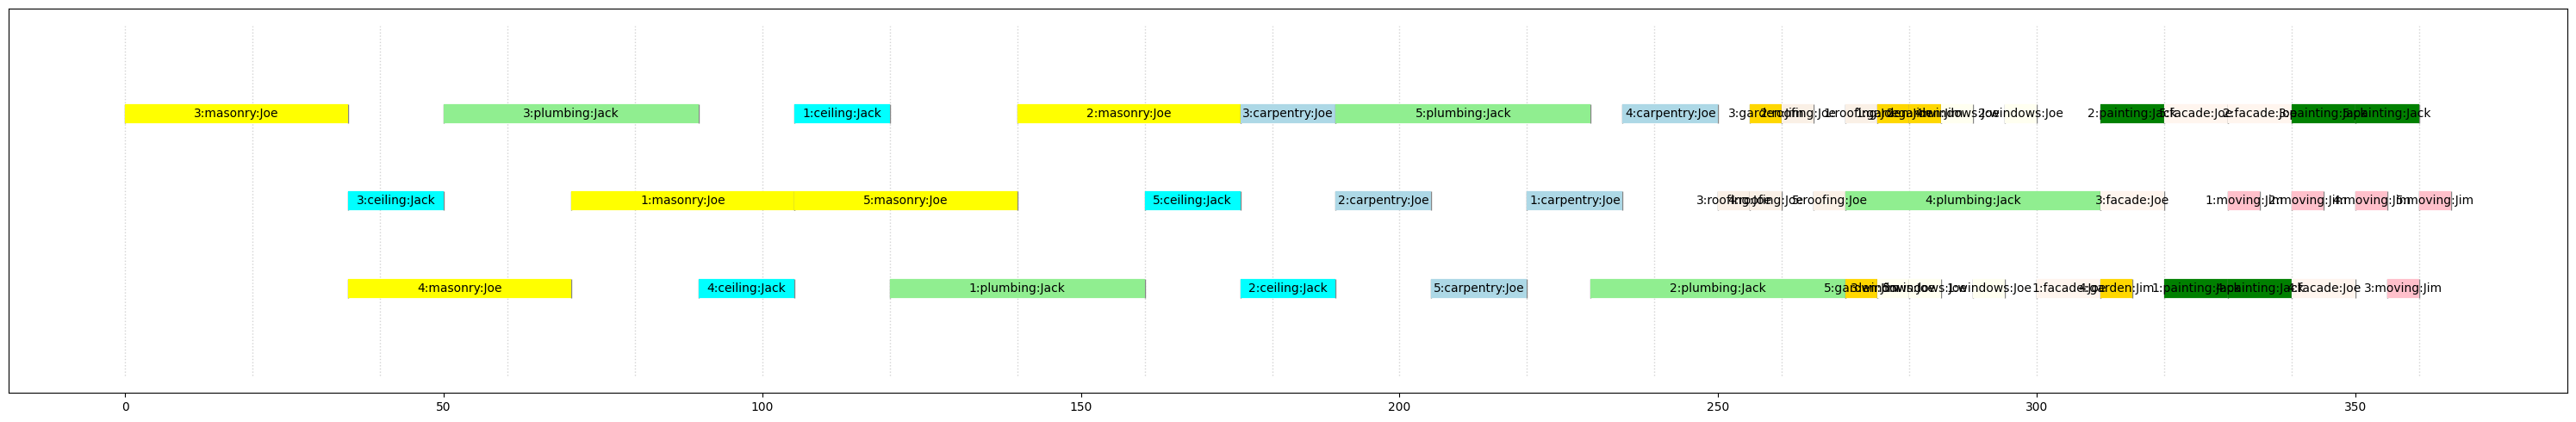

In [40]:
rcParams['figure.figsize'] = 30, 5
POP_UP_GRAPHIC=False

colors ={"masonry":'yellow',   "carpentry":'lightblue', "plumbing":  'lightgreen',"ceiling" :'cyan' ,"roofing":'linen',"painting":'green',"windows":'ivory',"facade":  'seashell',"garden":'gold',"moving":
 'pink'}

for i in tasks['TaskDV'].values:
    wt = msol.get_var_solution(i)  

    house = wt.get_name().split(" ")[0].split(":")[1]
    task = wt.get_name().split(" ")[1].split(":")[1]
    worker = u[ (u['house']==house) & (u['task']==task)]['worker'].values[0]


    visu.interval(wt, colors[task], ':'.join([house, task, worker])) 

visu.show()